In [2]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer

# Path to the folder where you uploaded the model files
model_folder = '/content/my_final_trained_model/'

# Load the model and tokenizer
model = DistilBertForSequenceClassification.from_pretrained(model_folder)
tokenizer = DistilBertTokenizer.from_pretrained(model_folder)

# Check if the model was loaded correctly
print(model)


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [3]:
import pandas as pd
import torch
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer
import numpy as np

# Load the datasets
kamala_df = pd.read_csv('/content/increased_harris_processed.csv')  # Update the path if needed
trump_df = pd.read_csv('/content/trump_processed.csv')  # Update the path if needed

# Ensure the 'processed_body' is a string column and handle missing values
kamala_df['processed_body'] = kamala_df['processed_body'].fillna('').astype(str)
trump_df['processed_body'] = trump_df['processed_body'].fillna('').astype(str)

# Check the structure of the datasets (Ensure 'processed_body' column exists)
print(kamala_df.head())
print(trump_df.head())

# Define the prediction function with batching
def predict_classes_in_batches(texts, model, tokenizer, device, batch_size=8, max_length=256):
    model.eval()
    all_preds = []
    valid_texts = []

    # Process data in batches
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]

        # Tokenize the batch
        encodings = tokenizer(
            batch_texts,
            truncation=True,
            padding=True,
            max_length=max_length,
            return_tensors='pt'
        )

        # Check for sequences that exceed the max length
        valid_indices = [idx for idx, seq_len in enumerate(encodings['input_ids']) if seq_len.size(0) <= max_length]
        valid_encodings = {key: val[valid_indices] for key, val in encodings.items()}  # Keep only valid entries
        valid_batch_texts = [batch_texts[idx] for idx in valid_indices]

        if len(valid_encodings['input_ids']) == 0:
            continue  # Skip if no valid sequences in this batch

        valid_texts.extend(valid_batch_texts)

        # Move to device
        valid_encodings = {key: val.to(device) for key, val in valid_encodings.items()}

        # Get predictions
        with torch.no_grad():
            outputs = model(**valid_encodings)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())  # Collect predictions

    return np.array(all_preds), valid_texts

# Set the device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load the model and tokenizer
model = DistilBertForSequenceClassification.from_pretrained('/content/my_final_trained_model')
tokenizer = DistilBertTokenizer.from_pretrained('/content/my_final_trained_model')

model.to(device)

# Predict classes for Kamala Harris dataset
kamala_predictions, valid_kamala_texts = predict_classes_in_batches(
    kamala_df['processed_body'].tolist(),
    model,
    tokenizer,
    device,
    batch_size=8,
    max_length=256
)
kamala_df = kamala_df.loc[kamala_df['processed_body'].isin(valid_kamala_texts)]
kamala_df['predictions'] = kamala_predictions

# Predict classes for Trump dataset
trump_predictions, valid_trump_texts = predict_classes_in_batches(
    trump_df['processed_body'].tolist(),
    model,
    tokenizer,
    device,
    batch_size=8,
    max_length=256
)
trump_df = trump_df.loc[trump_df['processed_body'].isin(valid_trump_texts)]
trump_df['predictions'] = trump_predictions

# Save the results to CSV
kamala_df.to_csv('/content/kamala_harris_predictions.csv', index=False)
trump_df.to_csv('/content/trump_predictions.csv', index=False)

# Check the first few rows of the prediction results
print(kamala_df.head())
print(trump_df.head())


   score                                     processed_body
0     44  i'd say harris is actually gaza's only hope at...
1      2  i don't understand the scenario where allred w...
2     16              baw gawd! thats kamala harris’ music!
3      3  here's the full article without blocks. "atlan...
4      5  and trump even after 4 years as president has ...
   score                                     processed_body
0     85  is there any internal discussions about how fa...
1     12  reputations are hard to maintain and easy to l...
2      9  i have seen a lot of fact checks on harris and...
3      8  is there pressure to try to balance out the fa...
4      2  thanks for taking the time and welcome. 1) how...
Using device: cpu
   score                                     processed_body  predictions
0     44  i'd say harris is actually gaza's only hope at...            2
1      2  i don't understand the scenario where allred w...            0
2     16              baw gawd! thats kamal

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
kamala_df = pd.read_csv('/content/kamala_harris_predictions.csv')
trump_df = pd.read_csv('/content/trump_predictions.csv')

# Add a 'candidate' column for distinction
kamala_df['candidate'] = 'Kamala Harris'
trump_df['candidate'] = 'Donald Trump'

# Combine datasets for comparative analysis
combined_df = pd.concat([kamala_df, trump_df], ignore_index=True)


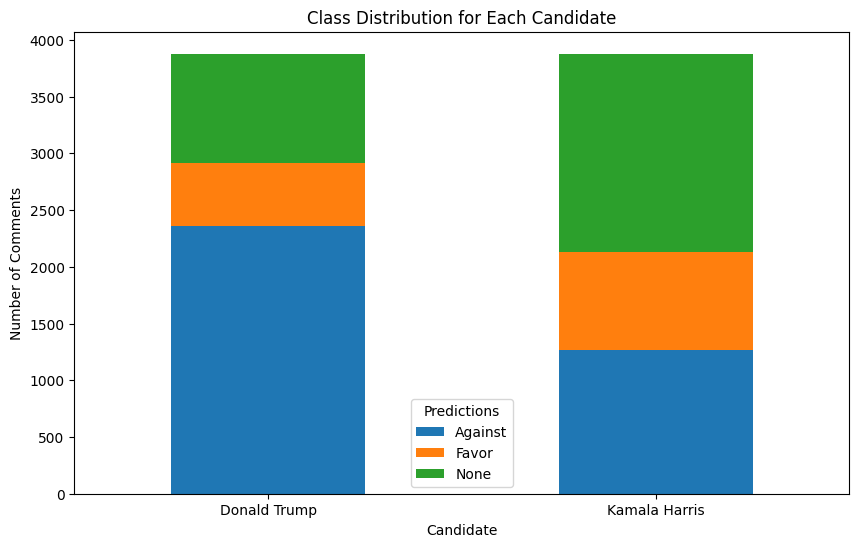

In [5]:
# Class distribution for each candidate
class_counts = combined_df.groupby(['candidate', 'predictions']).size().unstack()

# Visualization
class_counts.plot(kind='bar', figsize=(10, 6), stacked=True)
plt.title('Class Distribution for Each Candidate')
plt.xlabel('Candidate')
plt.ylabel('Number of Comments')
plt.xticks(rotation=0)
plt.legend(['Against', 'Favor', 'None'], title="Predictions")
plt.show()


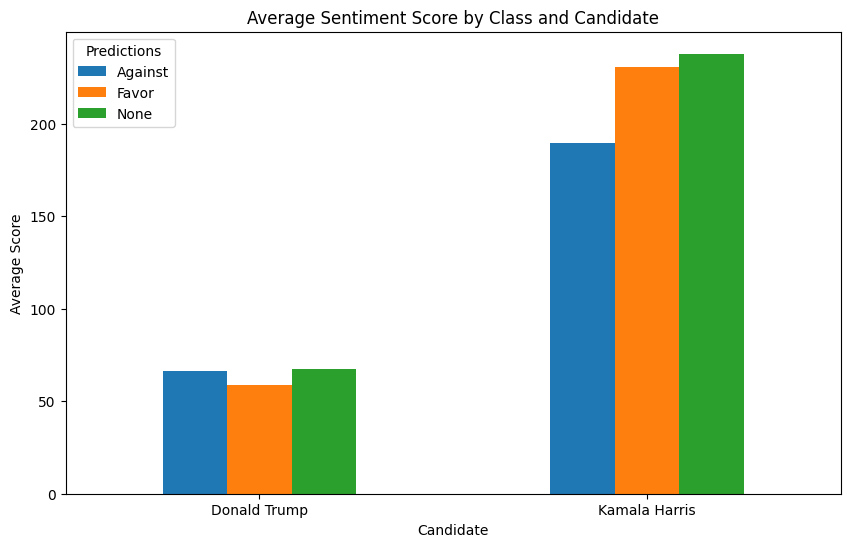

In [6]:
# Average score by candidate and prediction
avg_score = combined_df.groupby(['candidate', 'predictions'])['score'].mean().unstack()

# Visualization
avg_score.plot(kind='bar', figsize=(10, 6))
plt.title('Average Sentiment Score by Class and Candidate')
plt.xlabel('Candidate')
plt.ylabel('Average Score')
plt.xticks(rotation=0)
plt.legend(['Against', 'Favor', 'None'], title="Predictions")
plt.show()


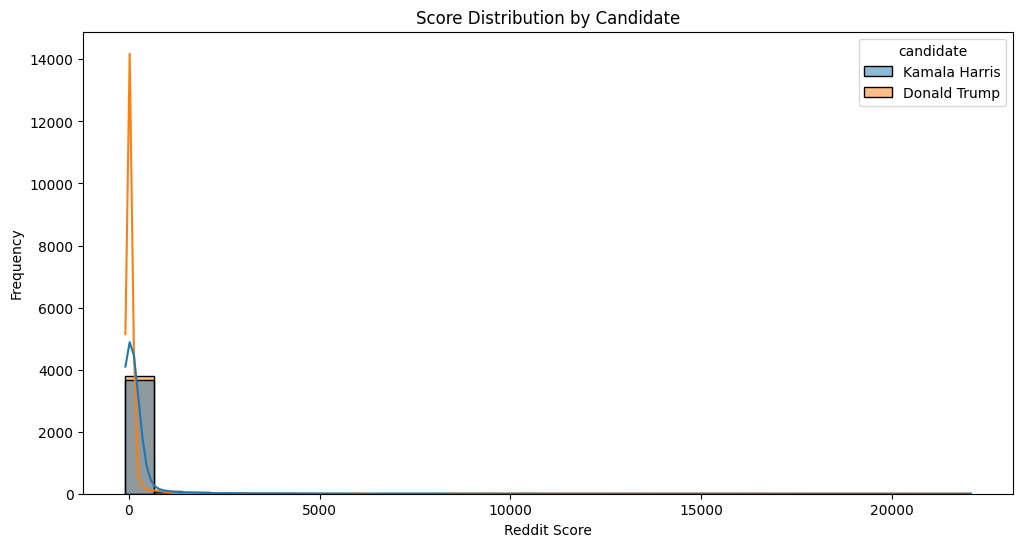

In [7]:
# Score distribution by candidate
plt.figure(figsize=(12, 6))
sns.histplot(data=combined_df, x='score', hue='candidate', kde=True, bins=30)
plt.title('Score Distribution by Candidate')
plt.xlabel('Reddit Score')
plt.ylabel('Frequency')
plt.show()


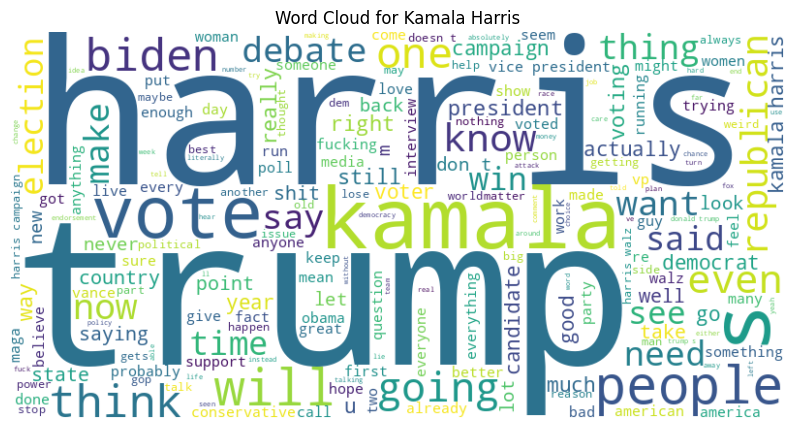

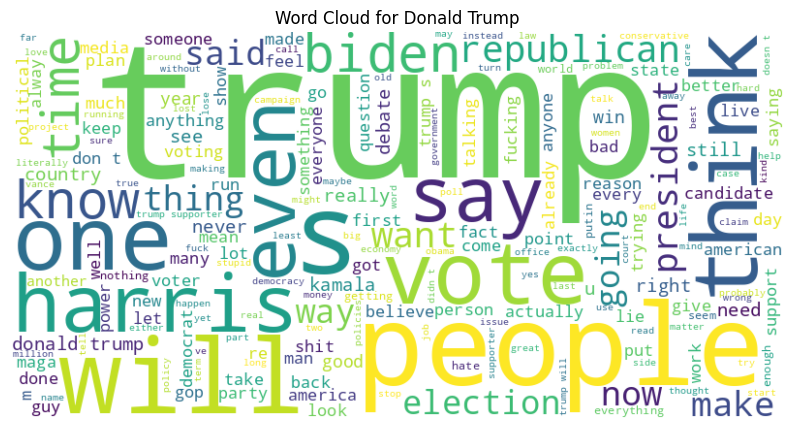

In [9]:
from wordcloud import WordCloud

# Ensure 'processed_body' is a string and fill missing values
combined_df['processed_body'] = combined_df['processed_body'].fillna('').astype(str)

# Generate word clouds
for candidate in ['Kamala Harris', 'Donald Trump']:
    text = ' '.join(combined_df[combined_df['candidate'] == candidate]['processed_body'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {candidate}')
    plt.show()


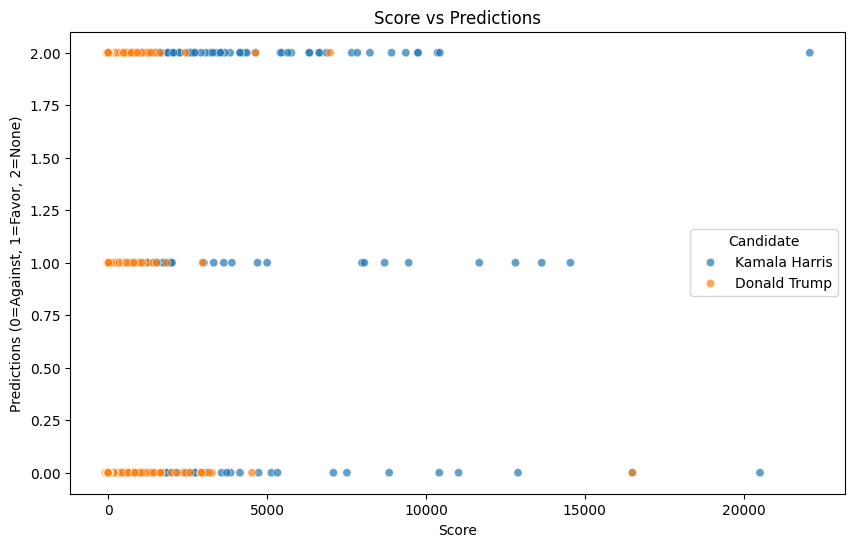

In [10]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=combined_df, x='score', y='predictions', hue='candidate', alpha=0.7)
plt.title('Score vs Predictions')
plt.xlabel('Score')
plt.ylabel('Predictions (0=Against, 1=Favor, 2=None)')
plt.legend(title='Candidate')
plt.show()


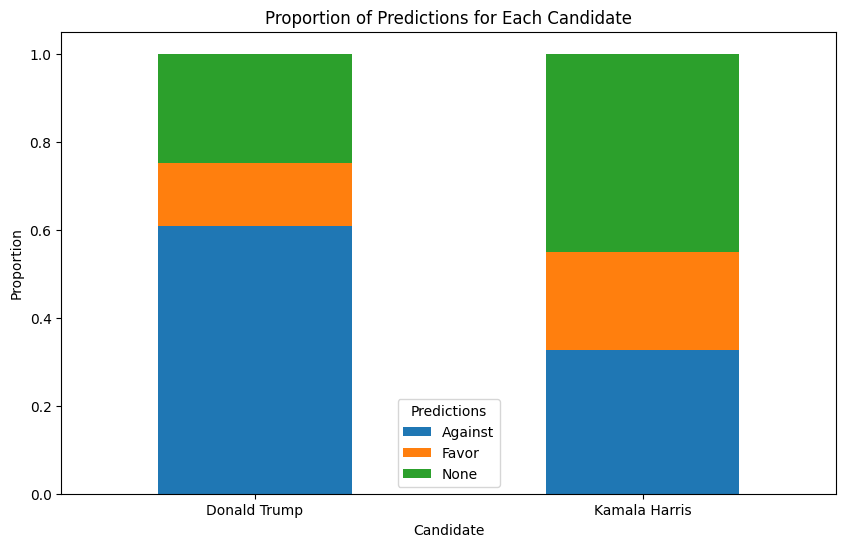

In [11]:
# Normalize prediction proportions by candidate
proportions = combined_df.groupby(['candidate', 'predictions']).size().unstack()
proportions = proportions.div(proportions.sum(axis=1), axis=0)

# Visualization
proportions.plot(kind='bar', figsize=(10, 6), stacked=True)
plt.title('Proportion of Predictions for Each Candidate')
plt.xlabel('Candidate')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.legend(['Against', 'Favor', 'None'], title="Predictions")
plt.show()


In [13]:
from collections import Counter
import nltk

nltk.download('punkt_tab')

# Function to extract frequent words
def get_frequent_words(df, prediction, num_words=20):
    text = ' '.join(df[df['predictions'] == prediction]['processed_body'])
    tokens = nltk.word_tokenize(text)
    return Counter(tokens).most_common(num_words)

# Example: Frequent words for "Favor" class
for candidate in ['Kamala Harris', 'Donald Trump']:
    print(f"Frequent words for {candidate} - Favor class:")
    print(get_frequent_words(combined_df[combined_df['candidate'] == candidate], prediction=1))
    print()


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Frequent words for Kamala Harris - Favor class:
[('.', 3636), ('the', 2991), (',', 2806), ('to', 2136), ('and', 2007), ('a', 1460), ('of', 1375), ('i', 1303), ('that', 1096), ('it', 1080), ('is', 992), ('’', 983), ('in', 933), ('for', 818), ('he', 796), ('trump', 588), ('they', 569), ('harris', 565), ("'s", 557), ('this', 541)]

Frequent words for Donald Trump - Favor class:
[('.', 1916), ('the', 1619), (',', 1498), ('to', 1086), ('and', 957), ('trump', 796), ('a', 665), ('of', 648), ('is', 613), ('i', 551), ('that', 482), ('in', 476), ('it', 454), ('he', 449), ('’', 395), ('for', 365), ('they', 355), ('this', 307), ('you', 291), ("'s", 289)]



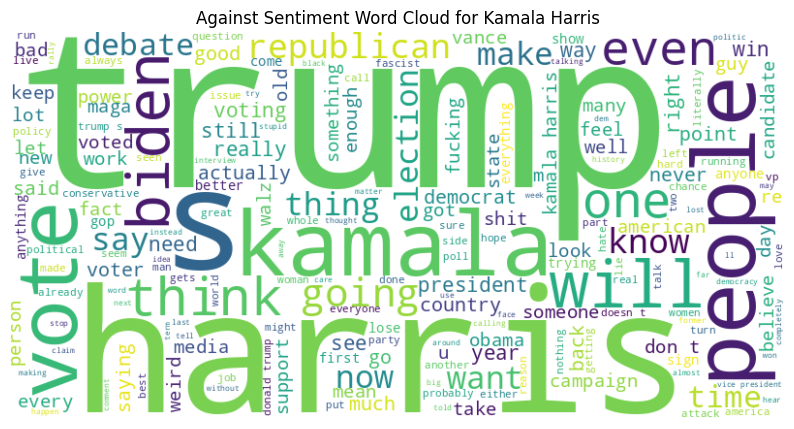

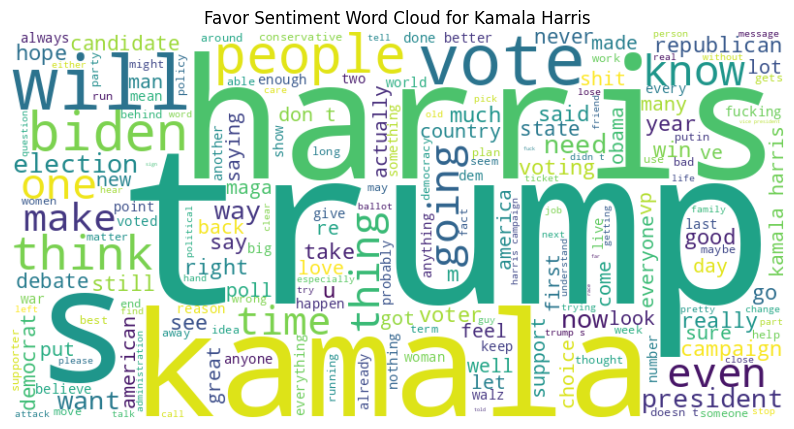

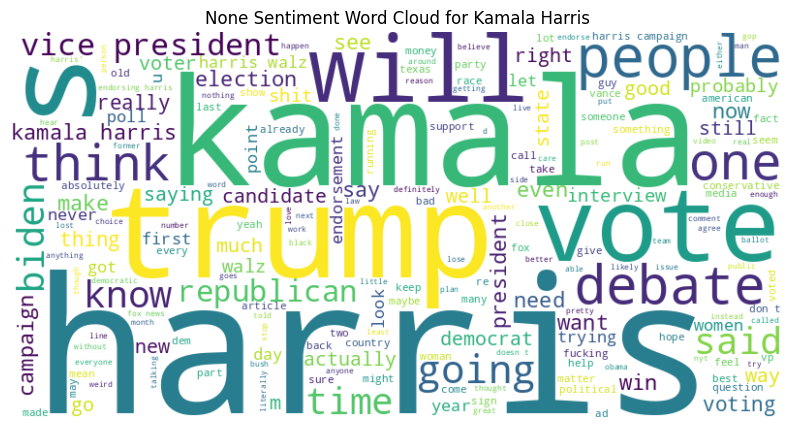

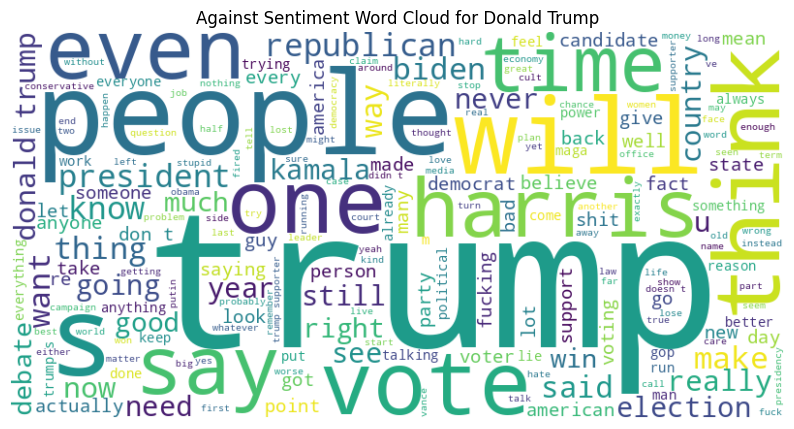

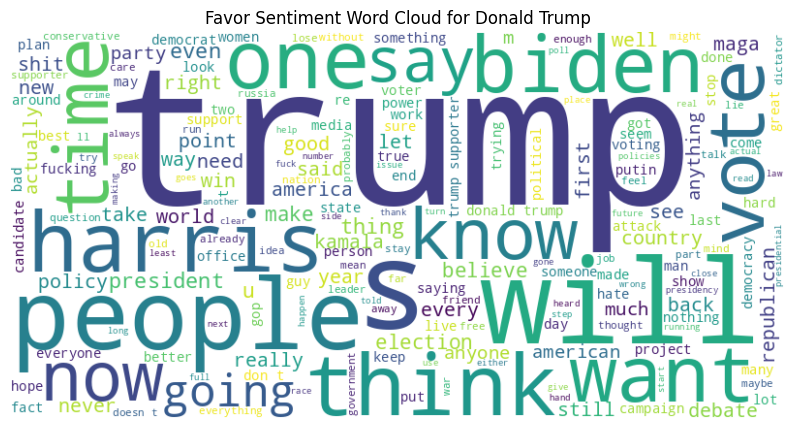

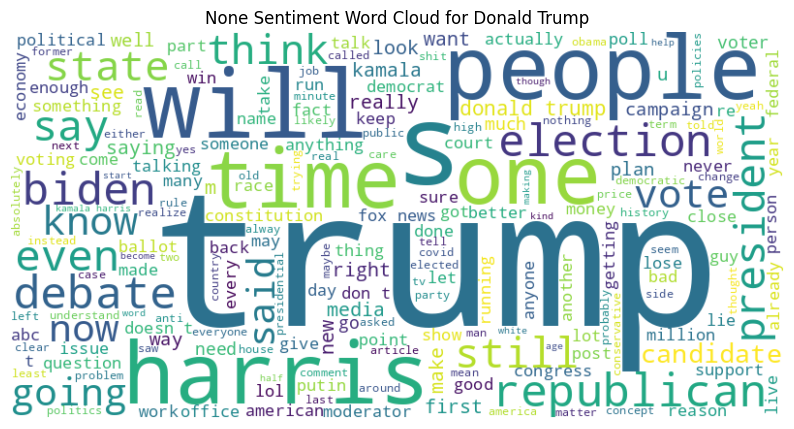

In [14]:
for candidate in ['Kamala Harris', 'Donald Trump']:
    for sentiment, label in zip([0, 1, 2], ['Against', 'Favor', 'None']):
        text = ' '.join(combined_df[(combined_df['candidate'] == candidate) &
                                    (combined_df['predictions'] == sentiment)]['processed_body'])
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
        plt.figure(figsize=(10, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'{label} Sentiment Word Cloud for {candidate}')
        plt.show()


In [15]:
top_kamala = combined_df[combined_df['candidate'] == 'Kamala Harris'].nlargest(5, 'score')
top_trump = combined_df[combined_df['candidate'] == 'Donald Trump'].nlargest(5, 'score')

print("Top 5 Kamala Harris Comments:")
print(top_kamala[['processed_body', 'score', 'predictions']])

print("\nTop 5 Donald Trump Comments:")
print(top_trump[['processed_body', 'score', 'predictions']])


Top 5 Kamala Harris Comments:
                                         processed_body  score  predictions
1638  billionaires being this reluctant to endorse k...  22079            2
752   > when the commotion started, harris smiled at...  20513            0
1111  for those unfamiliar with walz, he’s the curre...  16501            0
3359  [ the actual post. and the full text for those...  14547            1
2265  when trump was shot(?) and the photos of him l...  13644            1

Top 5 Donald Trump Comments:
                                         processed_body  score  predictions
7319  for those unfamiliar with walz, he’s the curre...  16494            0
6560  trump: they're executing babies at 9 months af...   6986            2
7419  well, if they want someone younger and with mo...   4639            2
6561  headlines better damn we’ll be a ranting trump...   4528            0
4566  jake tapper was literally on cnn the other day...   3269            0


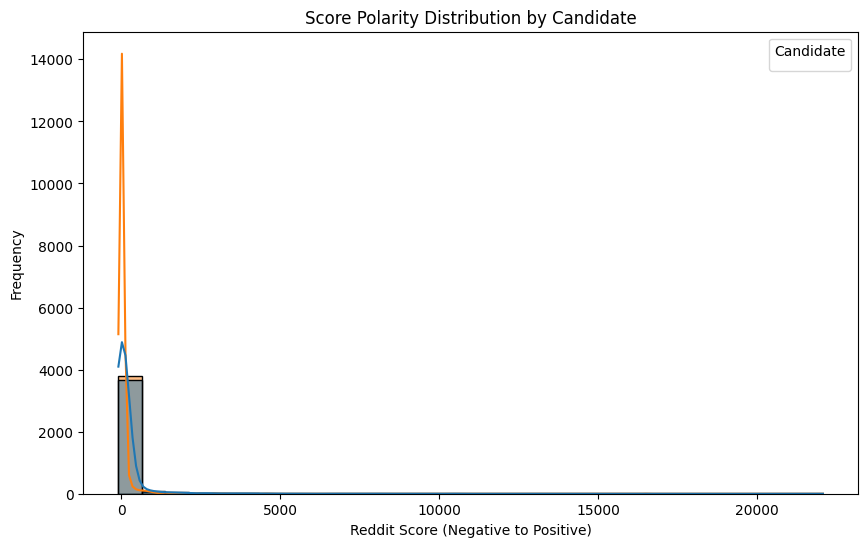

In [16]:
plt.figure(figsize=(10, 6))
sns.histplot(data=combined_df, x='score', hue='candidate', kde=True, bins=30)
plt.title('Score Polarity Distribution by Candidate')
plt.xlabel('Reddit Score (Negative to Positive)')
plt.ylabel('Frequency')
plt.legend(title='Candidate')
plt.show()


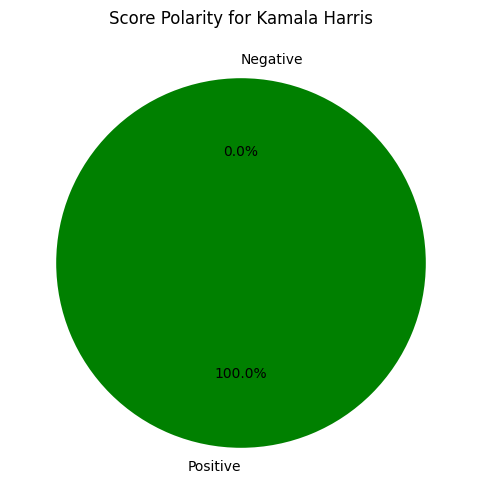

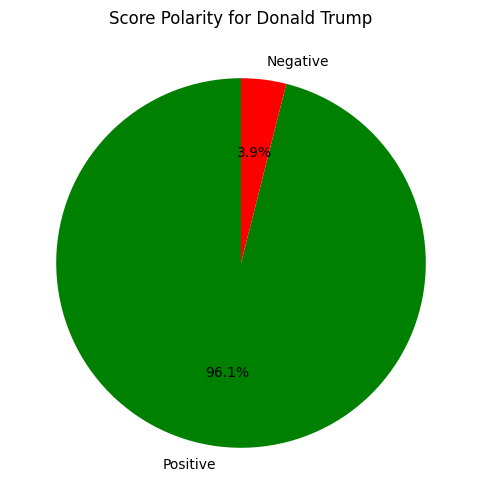

In [17]:
for candidate in ['Kamala Harris', 'Donald Trump']:
    candidate_data = combined_df[combined_df['candidate'] == candidate]
    positive_count = len(candidate_data[candidate_data['score'] > 0])
    negative_count = len(candidate_data[candidate_data['score'] <= 0])

    labels = ['Positive', 'Negative']
    sizes = [positive_count, negative_count]
    plt.figure(figsize=(6, 6))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['green', 'red'])
    plt.title(f'Score Polarity for {candidate}')
    plt.show()


In [18]:
for candidate in ['Kamala Harris', 'Donald Trump']:
    print(f"Top 3 Most Positive Comments for {candidate}:")
    print(combined_df[combined_df['candidate'] == candidate].nlargest(3, 'score')[['processed_body', 'score', 'predictions']])
    print("\nTop 3 Most Negative Comments for {candidate}:")
    print(combined_df[combined_df['candidate'] == candidate].nsmallest(3, 'score')[['processed_body', 'score', 'predictions']])
    print("\n")


Top 3 Most Positive Comments for Kamala Harris:
                                         processed_body  score  predictions
1638  billionaires being this reluctant to endorse k...  22079            2
752   > when the commotion started, harris smiled at...  20513            0
1111  for those unfamiliar with walz, he’s the curre...  16501            0

Top 3 Most Negative Comments for {candidate}:
                                        processed_body  score  predictions
227  my ole' man wouldn't have known this happened ...      1            1
855  to sort this thread by 'best comments first', ...      1            2
869  the last republican the nyt endorsed was liter...      1            2


Top 3 Most Positive Comments for Donald Trump:
                                         processed_body  score  predictions
7319  for those unfamiliar with walz, he’s the curre...  16494            0
6560  trump: they're executing babies at 9 months af...   6986            2
7419  well, if they want

In [19]:
correlations = combined_df.groupby('candidate').apply(
    lambda x: x[['score', 'predictions']].corr().iloc[0, 1]
)
print("Correlation between Score and Sentiment for Each Candidate:")
print(correlations)


Correlation between Score and Sentiment for Each Candidate:
candidate
Donald Trump    -0.000438
Kamala Harris    0.019160
dtype: float64


<ipython-input-19-54bab002223d>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  correlations = combined_df.groupby('candidate').apply(


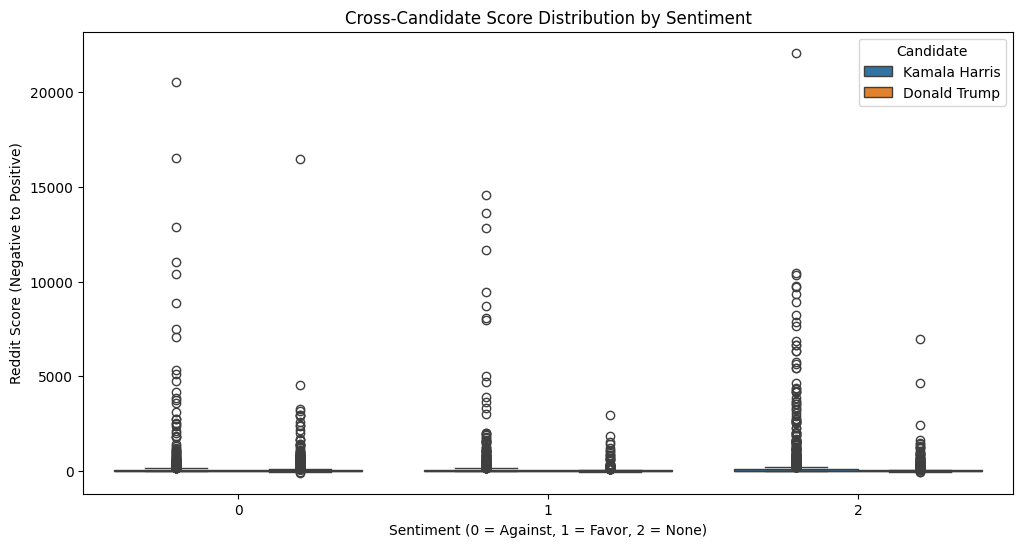

In [20]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=combined_df, x='predictions', y='score', hue='candidate')
plt.title('Cross-Candidate Score Distribution by Sentiment')
plt.xlabel('Sentiment (0 = Against, 1 = Favor, 2 = None)')
plt.ylabel('Reddit Score (Negative to Positive)')
plt.legend(title='Candidate')
plt.show()
